In [ ]:
%pip install wfdb numpy pandas matplotlib tensorflow imbalanced-learn seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import wfdb
import numpy as np
import pandas as pd

data = '/content/drive/MyDrive/mitdb1'


patients = [f.split('.')[0] for f in os.listdir(data) if f.endswith('.hea')]
patients = np.sort(patients)
labels_df = pd.DataFrame()

for pat_id in patients:
    file = os.path.join(data, pat_id)
    annotation = wfdb.rdann(file, 'atr')

    #sym is the annotated symbol read from the file
    labels = annotation.symbol

    #values is the different symbols in each patient
    #counts is the number of each symbol for said patient
    vals, cts = np.unique(labels, return_counts=True)

    #df_sub is a mini lil dataframe for each individual patient
    df_per_pat = pd.DataFrame({'Symbol':vals, 'Counts':cts, 'Patient':[pat_id]*len(cts)})
    labels_df = pd.concat([labels_df, df_per_pat],axis = 0)

labels_df.groupby('Symbol').Counts.sum().sort_values(ascending = False)

Symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [ ]:
AAMI_labels = [['N', 'L', 'R', 'e'], ['V', 'E'], ['S', 'J', 'A', 'a'], ['F'], ['/', 'f', 'j', 'a']]

classes = ['Normal', 'Ventricular', 'Supraventricular', 'Fusion', 'Other']

In [ ]:
# used to load in the entire ECG dataset,
# get the signal and label,
# read the symbols and signal

def load_ecg(file):

    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal
    symbol_ann = annotation.symbol
    sample_ann = annotation.sample

    return p_signal, symbol_ann, sample_ann

In [ ]:
# creates dataset for model training

def make_dataset(patients, seconds, frequency, classes):

  #set number of data points
  columns = 2 * seconds * frequency
  data_X = np.zeros((1,columns))
  data_Y = np.zeros((1,len(classes)))
  data_Labels = []

  rows_per_patient = []

  for pat in patients:
    file = os.path.join(data, pat)
    p_signal, symbol_ann, sample_ann = load_ecg(file)

    # only using one lead for simplicity
    p_signal = p_signal[:,0]

    # make df without the noise symbols
    df_data = pd.DataFrame({'symbol_ann':symbol_ann, 'sample_ann':sample_ann})
    #df_data = df_data.loc[df_data.symbol_ann.isin(classes)]
    df_data['symbol_ann'] = df_data['symbol_ann'].apply(lambda x: next((class_name for class_name, label_list in zip(classes, AAMI_labels) if x in label_list), 'Other'))



    rows = len(df_data)
    X = np.zeros((rows, columns))
    Y = np.zeros((rows,len(classes)))
    symbs = []

    # keep track of rows
    maximum_rows = 0

    for sample_ann, symbol_ann in zip(df_data.sample_ann.values,df_data.symbol_ann.values):
        left = max([0,(sample_ann - seconds * frequency) ])
        right = min([len(p_signal),(sample_ann + seconds * frequency) ])
        x = p_signal[left: right]
        if len(x) == columns:
            X[maximum_rows,:] = x
            class_index = classes.index(symbol_ann)
            Y[maximum_rows, class_index] = 1
            maximum_rows += 1

    X = X[:maximum_rows,:]
    Y = Y[:maximum_rows,:]

    data_Labels += df_data['symbol_ann'].tolist()
    data_X = np.append(data_X,X,axis = 0)
    data_Y = np.append(data_Y,Y,axis = 0)

  data_X = data_X[1:,:]
  data_Y = data_Y[1:,:]

  return data_X, data_Y, data_Labels

In [ ]:
X_data, Y_data, symbol_data = make_dataset(patients, 3, 360, classes)

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
import time


X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



model_cnn = models.Sequential([
    layers.Conv1D(16, 3, activation='relu', input_shape=(2160, 1), kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(4),
    layers.Conv1D(8, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(4),
    layers.Flatten(),
    layers.Dense(len(classes), activation='softmax')
])


model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()


start_time = time.time()
model_cnn.fit(X_train_cnn, y_train, epochs=5, validation_data=(X_valid_cnn, y_valid), batch_size=32)
print(f"Training Time: {time.time() - start_time:.2f} seconds")
test_loss, test_accuracy = model_cnn.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 2158, 16)          64        
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 539, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 537, 8)            392       
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 134, 8)            0         
 ng1D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 1072)              0         
                                                                 
 dense_34 (Dense)            (None, 5)               

527/527 [==============================] - 6s 12ms/step


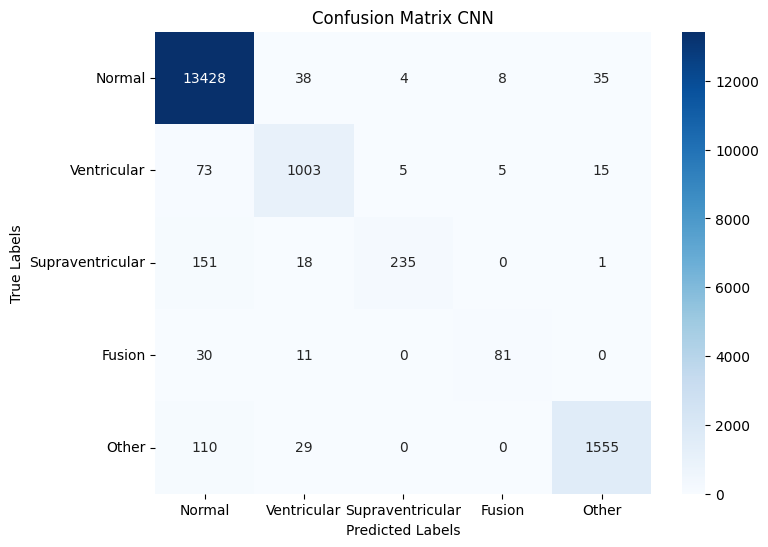

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_cnn.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_valid from one-hot encoded to class labels
y_valid_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid_classes, y_pred_classes)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,  # Replace with your class labels
            yticklabels=classes)  # Replace with your class labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix CNN')
plt.show()

In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn)
tflite_model_cnn = converter.convert()

with open('/content/drive/MyDrive/model_cnn.tflite', 'wb') as f:
    f.write(tflite_model_cnn)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
import time


model_rnn = models.Sequential([
    layers.SimpleRNN(32, input_shape=(2160, 1), return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(len(classes), activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
start_time = time.time()
model_rnn.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=32)
print(f"Training Time: {time.time() - start_time:.2f} seconds")

# Evaluate the model
test_loss_rnn, test_accuracy_rnn = model_rnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_rnn}")
print(f"Test Loss: {test_loss_rnn}")


Epoch 1/10
2456/2456 [==============================] - 492s 200ms/step - loss: 0.7313 - accuracy: 0.8008 - val_loss: 0.7053 - val_accuracy: 0.8067
Epoch 2/10
2456/2456 [==============================] - 489s 199ms/step - loss: 0.7094 - accuracy: 0.8020 - val_loss: 0.6822 - val_accuracy: 0.8067
Epoch 3/10
2456/2456 [==============================] - 488s 199ms/step - loss: 0.7036 - accuracy: 0.8020 - val_loss: 0.6859 - val_accuracy: 0.8067
Epoch 4/10
2456/2456 [==============================] - 487s 198ms/step - loss: 0.6993 - accuracy: 0.8020 - val_loss: 0.7028 - val_accuracy: 0.8067
Epoch 5/10
2456/2456 [==============================] - 484s 197ms/step - loss: 0.7015 - accuracy: 0.8020 - val_loss: 0.7029 - val_accuracy: 0.8067
Epoch 6/10
2456/2456 [==============================] - 48

In [ ]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 3525 (13.77 KB)
Trainable params: 3525 (13.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


527/527 [==============================] - 28s 52ms/step


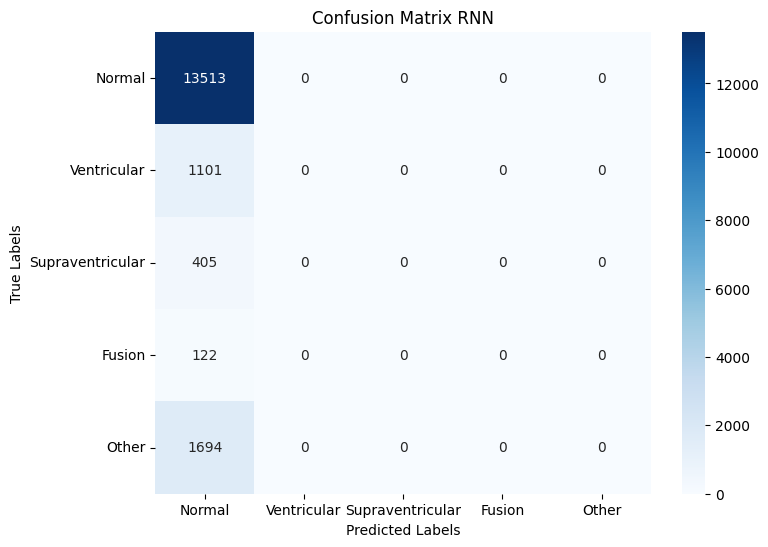

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



y_pred_rnn = model_rnn.predict(X_test)
y_pred_classes_rnn = np.argmax(y_pred_rnn, axis=1)

y_valid_classes_rnn = np.argmax(y_test, axis=1)

conf_matrix_rnn = confusion_matrix(y_valid_classes_rnn, y_pred_classes_rnn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rnn, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix RNN')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_rnn)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]


tflite_model_rnn = converter.convert()

with open('model_rnn.tflite', 'wb') as f:
    f.write(tflite_model_rnn)



INFO:tensorflow:Assets written to: /tmp/tmpaa6pkr6c/assets


INFO:tensorflow:Assets written to: /tmp/tmpaa6pkr6c/assets
2024-04-04 12:55:56.661358: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-04-04 12:55:56.661406: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-04-04 12:55:56.661837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpaa6pkr6c
2024-04-04 12:55:56.665287: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-04-04 12:55:56.665313: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpaa6pkr6c
2024-04-04 12:55:56.674731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-04-04 12:55:56.676683: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-04-04 12:55:56.727058: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
import time


model_lstm = models.Sequential([
    layers.LSTM(32, input_shape=(2160, 1), return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(len(classes), activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
eval_ltsm = model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=32)
print(f"Training Time: {time.time() - start_time:.2f} seconds")


test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {test_accuracy_lstm}")
print(f"Test Loss: {test_loss_lstm}")


Epoch 1/10
2456/2456 [==============================] - 1081s 440ms/step - loss: 0.7211 - accuracy: 0.8016 - val_loss: 0.6930 - val_accuracy: 0.8067
Epoch 2/10
2456/2456 [==============================] - 1074s 437ms/step - loss: 0.6970 - accuracy: 0.8018 - val_loss: 0.7062 - val_accuracy: 0.8067
Epoch 3/10
2456/2456 [==============================] - 1062s 433ms/step - loss: 0.7012 - accuracy: 0.8022 - val_loss: 0.6791 - val_accuracy: 0.7727
Epoch 4/10
2456/2456 [==============================] - 1004s 409ms/step - loss: 0.6941 - accuracy: 0.8015 - val_loss: 0.6601 - val_accuracy: 0.8067
Epoch 5/10
2456/2456 [==============================] - 1017s 414ms/step - loss: 0.6756 - accuracy: 0.8102 - val_loss: 0.7247 - val_accuracy: 0.8064
Epoch 6/10
2456/2456 [========================

In [ ]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 6789 (26.52 KB)
Trainable params: 6789 (26.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


527/527 [==============================] - 54s 102ms/step


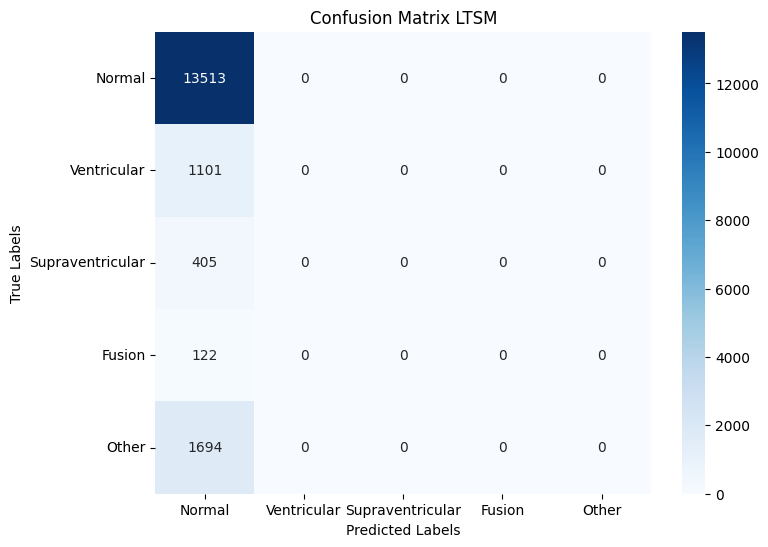

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_ltsm = model_lstm.predict(X_test)
y_pred_classes_ltsm = np.argmax(y_pred_ltsm, axis=1)

y_valid_classes__ltsm = np.argmax(y_test, axis=1)

conf_matrix_ltsm = confusion_matrix(y_valid_classes__ltsm, y_pred_classes_ltsm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ltsm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix LTSM')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]


tflite_model_ltsm = converter.convert()

with open('model_ltsm.tflite', 'wb') as f:
    f.write(tflite_model_ltsm)

INFO:tensorflow:Assets written to: /tmp/tmpiq6kr446/assets


INFO:tensorflow:Assets written to: /tmp/tmpiq6kr446/assets
2024-04-19 14:51:17.212663: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-04-19 14:51:17.212711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-04-19 14:51:17.213123: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiq6kr446
2024-04-19 14:51:17.220178: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-04-19 14:51:17.220204: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpiq6kr446
2024-04-19 14:51:17.244935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-04-19 14:51:17.249563: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-04-19 14:51:17.324955: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

In [ ]:
import os

size_cnn = os.path.getsize('model_cnn.tflite')
size_rnn = os.path.getsize('model_rnn.tflite')
size_lstm = os.path.getsize('model_ltsm.tflite')

print(f"CNN Model Size: {size_cnn} bytes")
print(f"RNN Model Size: {size_rnn} bytes")
print(f"LSTM Model Size: {size_lstm} bytes")


CNN Model Size: 8845016 bytes
RNN Model Size: 22908 bytes
LSTM Model Size: 37556 bytes


Text(0.5, 1.0, 'Evaluation LTSM')

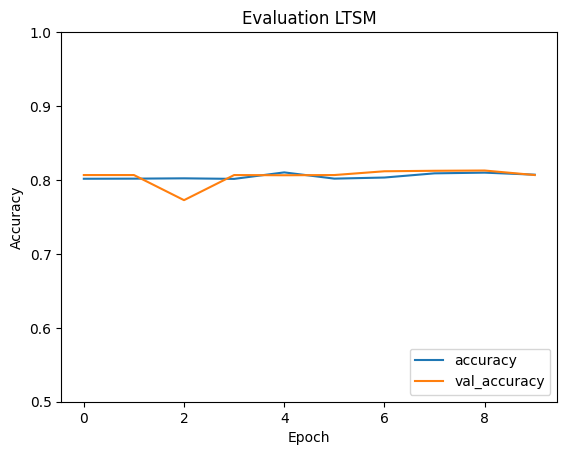

In [ ]:
plt.plot(eval_ltsm.history['accuracy'], label='accuracy')
plt.plot(eval_ltsm.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Evaluation LTSM')